In [1]:
import torch
print(f'PyTorch version: {torch.__version__}')

#print('*'*10)
#print(f'_CUDA version: ')
#!nvcc --version
#print('*'*10)
#print(f'CUDNN version: {torch.backends.cudnn.version()}')
#print(f'Available GPU devices: {torch.cuda.device_count()}')
#print(f'Device Name: {torch.cuda.get_device_name()}')

PyTorch version: 2.2.2


In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import numpy as np

import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\lib\site-packages\huggingface_hub\utils\_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


#### Load the complete CIFAR-10 dataset from https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

In [3]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


## DATA Preprocessing

In [4]:
# Get the length of datasets
print(len(train_dataset))
print(len(test_dataset))

50000
10000


In [5]:
# Get first image,label from the dataset. Print its shape.
image, label = train_dataset[0]
print(image.shape, label)

torch.Size([3, 32, 32]) 6


In [6]:
def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

In [7]:
mean, std = get_mean_and_std(train_dataset)
print(mean, std)

==> Computing mean and std..
tensor([0.4914, 0.4822, 0.4465]) tensor([0.2023, 0.1994, 0.2010])


In [8]:
transform_traindata = transforms.Compose([ transforms.ToTensor(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), ])

transform_testdata = transforms.Compose([ transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), ])

In [9]:
# initialize data loaders
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_traindata)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_testdata)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## Basic and Bottleneck residual blocks

In [10]:
class ResnetBasic(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(ResnetBasic, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [11]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

## Modified ResNet

In [12]:
class ModifiedResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ModifiedResNet, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

## Modified Pre Activation ResNet

In [13]:
class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out += shortcut
        return out

class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(PreActResNet, self).__init__()
        self.in_planes = 32

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [14]:
# Check number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Create the models
resNet18 = ModifiedResNet(ResnetBasic, [3,3,3,3])
resNet50 = ModifiedResNet(Bottleneck, [3,5,6,2])
preActResNet = PreActResNet(PreActBlock, [3,3,5,3])

## Display the Number of Parameters of the Modified Resnet Model

In [15]:
# Total Parameters of the Basic Resnet Model
print(f"ResNet18 - Number of trainable parameters: {count_parameters(resNet18)}")
print(f"ResNet50 - Number of trainable parameters: {count_parameters(resNet50)}")
print(f"preActResNet - Number of trainable parameters: {count_parameters(preActResNet)}")

ResNet18 - Number of trainable parameters: 4366250
ResNet50 - Number of trainable parameters: 4852266
preActResNet - Number of trainable parameters: 4955690


In [16]:
from torchsummary import summary
summary(resNet18, input_size=(3, 32, 32))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            864
├─BatchNorm2d: 1-2                       64
├─Sequential: 1-3                        --
|    └─ResnetBasic: 2-1                  --
|    |    └─Conv2d: 3-1                  9,216
|    |    └─BatchNorm2d: 3-2             64
|    |    └─Conv2d: 3-3                  9,216
|    |    └─BatchNorm2d: 3-4             64
|    |    └─Sequential: 3-5              --
|    └─ResnetBasic: 2-2                  --
|    |    └─Conv2d: 3-6                  9,216
|    |    └─BatchNorm2d: 3-7             64
|    |    └─Conv2d: 3-8                  9,216
|    |    └─BatchNorm2d: 3-9             64
|    |    └─Sequential: 3-10             --
|    └─ResnetBasic: 2-3                  --
|    |    └─Conv2d: 3-11                 9,216
|    |    └─BatchNorm2d: 3-12            64
|    |    └─Conv2d: 3-13                 9,216
|    |    └─BatchNorm2d: 3-14            64
|    |    └─Sequential: 3-15             --
├─Sequen

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            864
├─BatchNorm2d: 1-2                       64
├─Sequential: 1-3                        --
|    └─ResnetBasic: 2-1                  --
|    |    └─Conv2d: 3-1                  9,216
|    |    └─BatchNorm2d: 3-2             64
|    |    └─Conv2d: 3-3                  9,216
|    |    └─BatchNorm2d: 3-4             64
|    |    └─Sequential: 3-5              --
|    └─ResnetBasic: 2-2                  --
|    |    └─Conv2d: 3-6                  9,216
|    |    └─BatchNorm2d: 3-7             64
|    |    └─Conv2d: 3-8                  9,216
|    |    └─BatchNorm2d: 3-9             64
|    |    └─Sequential: 3-10             --
|    └─ResnetBasic: 2-3                  --
|    |    └─Conv2d: 3-11                 9,216
|    |    └─BatchNorm2d: 3-12            64
|    |    └─Conv2d: 3-13                 9,216
|    |    └─BatchNorm2d: 3-14            64
|    |    └─Sequential: 3-15             --
├─Sequen

In [17]:
from torchsummary import summary
summary(resNet50, input_size=(3, 32, 32))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            864
├─BatchNorm2d: 1-2                       64
├─Sequential: 1-3                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  1,024
|    |    └─BatchNorm2d: 3-2             64
|    |    └─Conv2d: 3-3                  9,216
|    |    └─BatchNorm2d: 3-4             64
|    |    └─Conv2d: 3-5                  4,096
|    |    └─BatchNorm2d: 3-6             256
|    |    └─Sequential: 3-7              4,352
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-8                  4,096
|    |    └─BatchNorm2d: 3-9             64
|    |    └─Conv2d: 3-10                 9,216
|    |    └─BatchNorm2d: 3-11            64
|    |    └─Conv2d: 3-12                 4,096
|    |    └─BatchNorm2d: 3-13            256
|    |    └─Sequential: 3-14             --
|    └─Bottleneck: 2-3                   --
|    |    └─Conv2d: 3-15                 4,096


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            864
├─BatchNorm2d: 1-2                       64
├─Sequential: 1-3                        --
|    └─Bottleneck: 2-1                   --
|    |    └─Conv2d: 3-1                  1,024
|    |    └─BatchNorm2d: 3-2             64
|    |    └─Conv2d: 3-3                  9,216
|    |    └─BatchNorm2d: 3-4             64
|    |    └─Conv2d: 3-5                  4,096
|    |    └─BatchNorm2d: 3-6             256
|    |    └─Sequential: 3-7              4,352
|    └─Bottleneck: 2-2                   --
|    |    └─Conv2d: 3-8                  4,096
|    |    └─BatchNorm2d: 3-9             64
|    |    └─Conv2d: 3-10                 9,216
|    |    └─BatchNorm2d: 3-11            64
|    |    └─Conv2d: 3-12                 4,096
|    |    └─BatchNorm2d: 3-13            256
|    |    └─Sequential: 3-14             --
|    └─Bottleneck: 2-3                   --
|    |    └─Conv2d: 3-15                 4,096


In [18]:
from torchsummary import summary
summary(preActResNet, input_size=(3, 32, 32))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            864
├─Sequential: 1-2                        --
|    └─PreActBlock: 2-1                  --
|    |    └─BatchNorm2d: 3-1             64
|    |    └─Conv2d: 3-2                  9,216
|    |    └─BatchNorm2d: 3-3             64
|    |    └─Conv2d: 3-4                  9,216
|    └─PreActBlock: 2-2                  --
|    |    └─BatchNorm2d: 3-5             64
|    |    └─Conv2d: 3-6                  9,216
|    |    └─BatchNorm2d: 3-7             64
|    |    └─Conv2d: 3-8                  9,216
|    └─PreActBlock: 2-3                  --
|    |    └─BatchNorm2d: 3-9             64
|    |    └─Conv2d: 3-10                 9,216
|    |    └─BatchNorm2d: 3-11            64
|    |    └─Conv2d: 3-12                 9,216
├─Sequential: 1-3                        --
|    └─PreActBlock: 2-4                  --
|    |    └─BatchNorm2d: 3-13            64
|    |    └─Conv2d: 3-14                 18,432
|   

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            864
├─Sequential: 1-2                        --
|    └─PreActBlock: 2-1                  --
|    |    └─BatchNorm2d: 3-1             64
|    |    └─Conv2d: 3-2                  9,216
|    |    └─BatchNorm2d: 3-3             64
|    |    └─Conv2d: 3-4                  9,216
|    └─PreActBlock: 2-2                  --
|    |    └─BatchNorm2d: 3-5             64
|    |    └─Conv2d: 3-6                  9,216
|    |    └─BatchNorm2d: 3-7             64
|    |    └─Conv2d: 3-8                  9,216
|    └─PreActBlock: 2-3                  --
|    |    └─BatchNorm2d: 3-9             64
|    |    └─Conv2d: 3-10                 9,216
|    |    └─BatchNorm2d: 3-11            64
|    |    └─Conv2d: 3-12                 9,216
├─Sequential: 1-3                        --
|    └─PreActBlock: 2-4                  --
|    |    └─BatchNorm2d: 3-13            64
|    |    └─Conv2d: 3-14                 18,432
|   

#### Train method

In [19]:
def train_model(model, train_dataloader, criterion, optimizer, epochs=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()

    # Initialize vars
    train_loss_history = []
    train_accuracy_history = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_total = 0
        running_correct = 0
        for i, data in enumerate(train_dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # capture running loss and accuracy
            _, predicted = outputs.max(1)
            running_loss += loss.item()
            running_total += labels.size(0)
            running_correct += predicted.eq(labels).sum().item()
            
        # Calculate train loss and accuracy, and store history data
        train_loss_history += [running_loss/running_total]
        train_accuracy_history += [100*running_correct/running_total]

    #print('Final Training Accuracy is : %.3f' % (train_accuracy_history[len(train_accuracy_history)-1]))

    # return these values for Plotting
    return train_loss_history, train_accuracy_history

#### Evaluate Method

In [20]:
def evaluate_model(model, test_dataloader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    # array vars
    test_loss_history = []
    test_accuracy_history = []

    with torch.no_grad():
        running_loss = 0.0        # Initialize the variable
        running_total = 0
        running_correct = 0
        for data in test_dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, labels)
            
            # capture running loss and accuracy
            _, predicted = torch.max(outputs.data, 1)
            running_loss += loss.item()
            running_total += labels.size(0)
            running_correct += predicted.eq(labels).sum().item()

        # Calculate train loss and accuracy, and store history data
        test_loss_history += [running_loss/running_total]
        test_accuracy_history += [100*running_correct/running_total]

    #print('Accuracy of the network on the 10000 test images: %d %%' % test_accuracy_history[len(test_accuracy_history)-1])

    # return these values for Plotting
    return test_loss_history, test_accuracy_history

#### Train and Evaluate Models

In [32]:
def train_and_eval(model,model_descriptor, train_dataloader, test_dataloader, optimizer, epochs):
    # Use EPOCH_COUNT. 
    # Train the model. Store the return values to train_loss_hist, train_accuracy_hist for Plotting
    #Evaluate the model. Store the return values to test_loss_hist, test_accuracy_hist for Plotting
    train_loss_hist = {}
    train_accuracy_hist = {}
    test_loss_hist = {}
    test_accuracy_hist = {}
    for epoch in range(epochs):
        train_loss_hist[epoch], train_accuracy_hist[epoch] = train_model(model, train_dataloader, criterion, optimizer, 1)
        test_loss_hist[epoch], test_accuracy_hist[epoch] = evaluate_model(model, test_dataloader)
        if epoch % 9 == 0:
            torch.save(model.state_dict(), f'{model_descriptor}-{epoch+1}.pt')
    
    train_loss = np.array(list(train_loss_hist.values())).squeeze()
    test_loss = np.array(list(test_loss_hist.values())).squeeze()
    train_accuracy = np.array(list(train_accuracy_hist.values())).squeeze()
    test_accuracy = np.array(list(test_accuracy_hist.values())).squeeze()
    
    return train_loss, train_accuracy, test_loss, test_accuracy
    

#### Plotting Graphs: Loss and Accuracy of the Train and Test data

In [22]:
# Plot the Train_Accuracy and Test_Accuracy history data
def plot_loss_accuracy(train_loss, test_loss, train_accuracy, test_accuracy):
    plt.plot(train_loss,'-', linewidth=3, label='Train loss')
    plt.plot(test_loss,'-', linewidth=3, label='Test loss')
    plt.title('Train vs Test loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    plt.plot(train_accuracy,'-', linewidth=3, label='Train accuracy')
    plt.plot(test_accuracy,'-', linewidth=3, label='Test accuracy')
    plt.title('Train Accuracy vs Test Accuracy ')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.show()

In [23]:
# Variables required for Plotting
EPOCH_COUNT = 50
criterion = nn.CrossEntropyLoss()
#optimizer = optim.AdamW(resNet18.parameters(), lr=1e-3, weight_decay=1e-4)
resNet18_optimizer = optim.SGD(resNet18.parameters(), lr=0.01, momentum=0.9)
resNet50_optimizer = optim.SGD(resNet50.parameters(), lr=0.01, momentum=0.9)
preActResNet_optimizer = optim.SGD(preActResNet.parameters(), lr=0.01, momentum=0.9)
#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

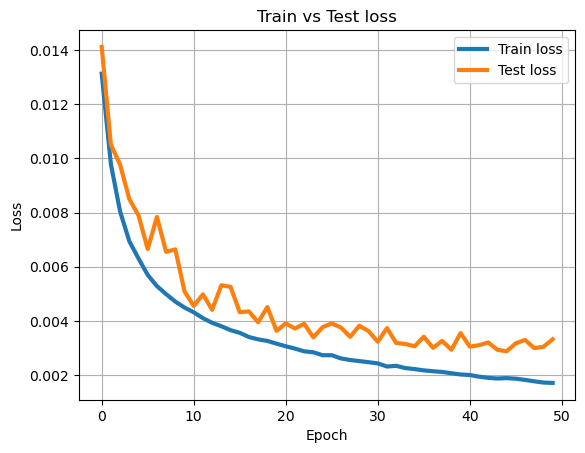

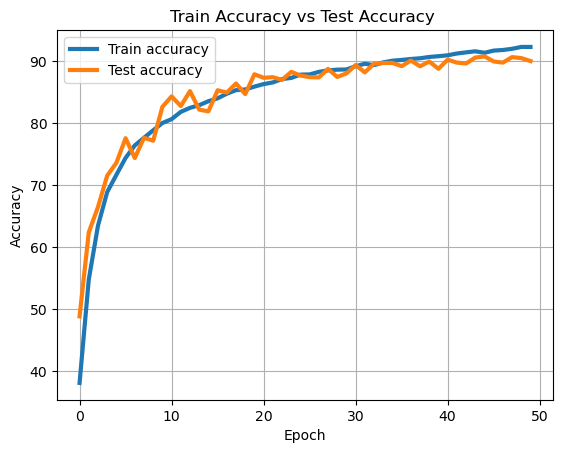

In [24]:
train_loss, train_accuracy, test_loss, resNet18_test_accuracy = train_and_eval(resNet18,'resnet18', train_dataloader, test_dataloader, resNet18_optimizer, EPOCH_COUNT)

plot_loss_accuracy(train_loss, test_loss, train_accuracy, resNet18_test_accuracy)

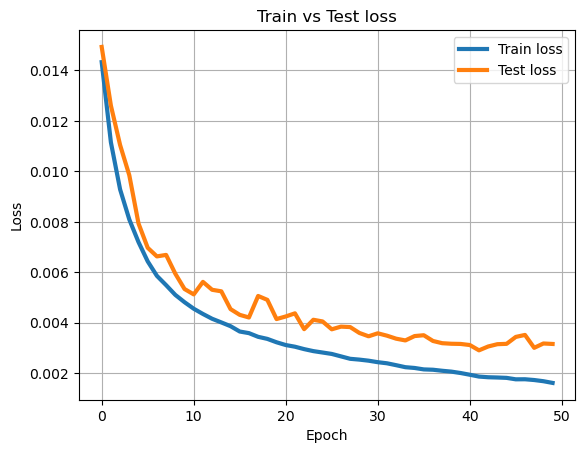

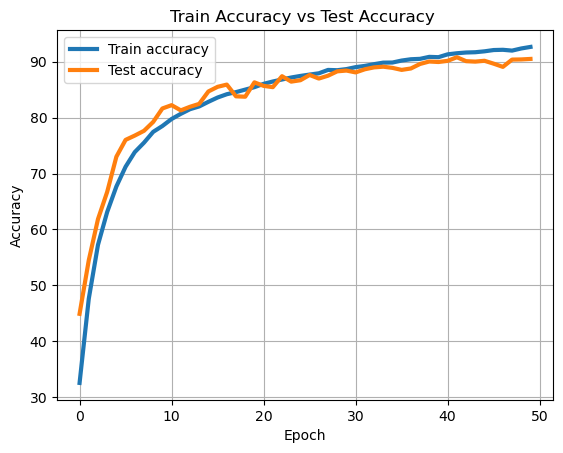

In [25]:
train_loss, train_accuracy, test_loss, resNet50_test_accuracy = train_and_eval(resNet50,'resnet50', train_dataloader, test_dataloader, resNet50_optimizer, EPOCH_COUNT)
plot_loss_accuracy(train_loss, test_loss, train_accuracy, resNet50_test_accuracy)

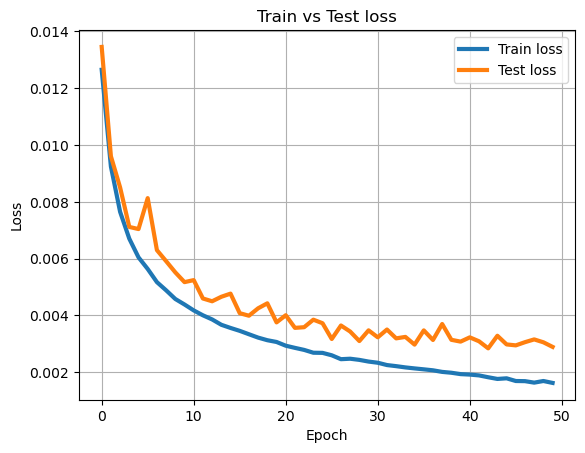

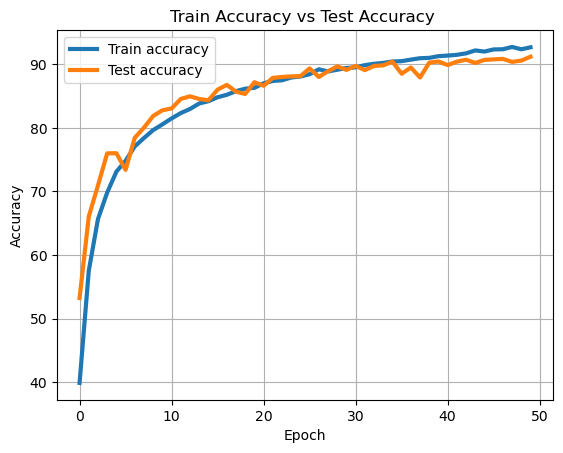

In [26]:
train_loss, train_accuracy, test_loss, preActResNet_test_accuracy = train_and_eval(preActResNet,'preActResNet', train_dataloader, test_dataloader, preActResNet_optimizer, EPOCH_COUNT)
plot_loss_accuracy(train_loss, test_loss, train_accuracy, preActResNet_test_accuracy)

In [39]:
print(f'RestNet18 accuracy: {resNet18_test_accuracy.max()} epoch: {list(resNet18_test_accuracy).index(resNet18_test_accuracy.max())}')
print(f'resNet50 accuracy: {resNet50_test_accuracy.max()} epoch: {list(resNet50_test_accuracy).index(resNet50_test_accuracy.max())}')
print(f'preActResNet accuracy: {preActResNet_test_accuracy.max()} epoch: {list(preActResNet_test_accuracy).index(preActResNet_test_accuracy.max())}')

RestNet18 accuracy: 90.79 epoch: 44
resNet50 accuracy: 90.81 epoch: 41
preActResNet accuracy: 91.19 epoch: 49


#### Kaggle submission

In [27]:
transform_nolabel_data = transforms.Compose([ transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), ])

#model = DenseNet(DenseBottleneck, [6,12,24,16], growth_rate=27)
#model.load_state_dict(torch.load("denseNet.pt"))

#model = PreActResNet(PreActBlock, [3,3,5,3])
#model.load_state_dict(torch.load("preActResNet.pt"))
model = preActResNet

In [28]:
import csv

def generate_submission_csv(model, cifar_nolabels):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    with torch.no_grad():
        images = cifar_nolabels[b'data'].reshape((-1, 3, 32, 32))
        images = np.transpose(images, (0,2,3,1))
        img_tensor = torch.stack([transform_nolabel_data(img) for img in images]).float().to(device)
        outputs = model(img_tensor)
        _, predicted = torch.max(outputs.data, 1)

    predTuple = list(zip(cifar_nolabels[b'ids'],predicted.cpu().numpy()))

    with open('predictions.csv','w',newline='') as out:
        csv_out=csv.writer(out)
        csv_out.writerow(['ID','Labels'])
        csv_out.writerows(predTuple)


In [29]:
import pickle
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

cifar_nolabels = load_cifar_batch('./data/cifar_test_nolabels.pkl')
generate_submission_csv(model, cifar_nolabels)


##### References: Lecture Notes, Resnet model from github of kuangliu